In [1]:
%load_ext autoreload

In [38]:
%autoreload 2
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

sys.path.append("../../../../repos/neur_stab/nsta")
from core import estimate_stability_using_particle

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

In [54]:
plt.style.use('../../sci_style.py')

# Signal In

In [35]:
area1 = 'vlPFC'
if area1 == 'all':
    area1_indices = np.arange(len(electrode_info['area']))
else:
    area1_indices = np.where(electrode_info['area'] == area1)[0]
    
area2 = 'CPB'
if area2 == 'all':
    area2_indices = np.arange(len(electrode_info['area']))
else:
    area2_indices = np.where(electrode_info['area'] == area2)[0]

big_window_start = 30*60 # s
big_window_length = 60 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
big_signal_area1 = lfp[big_window_start_ind:big_window_end_ind, area1_indices]
big_signal_area2 = lfp[big_window_start_ind:big_window_end_ind, area2_indices]

# Basic RRR

In [43]:
def OLS(X, Y, lamb=0):
    # compute ordinary least squares regression
    B_OLS = np.linalg.inv(X.T @ X + lamb*np.eye(X.shape[1])) @ X.T @ Y
    Y_hat_OLS = X @ B_OLS

    Rsquared_OLS = r2_score(Y, Y_hat_OLS)
    
    return B_OLS, Y_hat_OLS, Rsquared_OLS

def reduced_rank_regression_analysis(X, Y, m_range=np.arange(1, 11), lamb=0):
    
    B_OLS, Y_hat_OLS, Rsquared_OLS = OLS(X, Y, lamb)
    
    _, S, V_T = np.linalg.svd(Y_hat_OLS)
    
    RRR_data = {}
    for m in m_range:
        V = V_T[:m].T
        B_RRR = B_OLS@V@V.T
        Y_hat_RRR = X @ B_RRR

        Rsquared_RRR = r2_score(Y, Y_hat_RRR)
        
        RRR_data[m] = {'B_RRR': B_RRR, 'Y_hat_RRR': Y_hat_RRR, 'Rsquared_RRR': Rsquared_RRR}
    
    return RRR_data, B_OLS, Y_hat_OLS, Rsquared_OLS, S, V_T.T

In [41]:
m_range = np.arange(1, 11)
lamb = 0
thresh = 0.99
RRR_data, B_OLS, Y_hat_OLS, Rsquared_OLS, S, V = reduced_rank_regression_analysis(big_signal_area1[:10000], big_signal_area2[:10000], m_range=m_range, lamb=lamb)

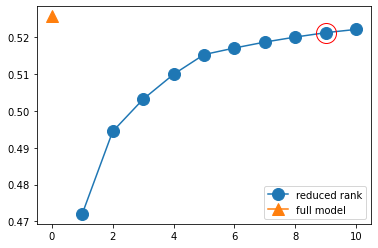

In [42]:
Rsquared_RRRs = [RRR_data[m]['Rsquared_RRR'] for m in m_range]
plt.plot(m_range, Rsquared_RRRs, 'o-', markersize=12, label='reduced rank')
plt.plot(0, Rsquared_OLS, markersize=12, marker="^", label='full model')
selected_dim_ind = np.argmax(Rsquared_RRRs > thresh*Rsquared_OLS)
selected_dim = m_range[selected_dim_ind]
plt.plot(selected_dim, Rsquared_RRRs[selected_dim_ind], marker='o', markerfacecolor='none', markeredgecolor='r', markersize=20)
plt.legend()
plt.show()

# Testing Out Delays

In [79]:
delays = np.arange(5000) # ms
window = 10000 # ms
T_pred = 100 # ms
num_window_samples = 3

In [84]:
min_ind = int(0/window)
max_ind = int((big_signal_area1.shape[0] - window - T_pred)/window)
possible_inds = np.arange(min_ind, max_ind)
window_inds = np.random.choice(possible_inds, size=(num_window_samples,), replace=False)

In [86]:
rsquared_vals = np.zeros((num_window_samples, len(delays)))
train_MSE = np.zeros((num_window_samples, len(delays)))
test_MSE = np.zeros((num_window_samples, len(delays)))
iterator = tqdm(total=num_window_samples*len(delays))
for i, window_ind in enumerate(window_inds):
    for delay in delays:
        X_train = big_signal_area1[window_ind*window:(window_ind + 1)*window - delay]
        Y_train = big_signal_area2[window_ind*window + delay:(window_ind + 1)*window]
        B_OLS, Y_hat_OLS, Rsquared_OLS = OLS(X_train, Y_train)
        rsquared_vals[i, delay] = Rsquared_OLS
        train_MSE[i, delay] = ((Y_train - Y_hat_OLS)**2).mean()

        X_test = big_signal_area1[(window_ind + 1)*window - delay:(window_ind + 1)*window - delay + T_pred]
        Y_test = big_signal_area2[(window_ind + 1)*window:(window_ind + 1)*window + T_pred]
        Y_hat_test = X_test @ B_OLS
        test_MSE[i, delay] = ((Y_test - Y_hat_test)**2).mean()
        
        iterator.update()
iterator.close()

  0%|          | 0/15000 [00:00<?, ?it/s]

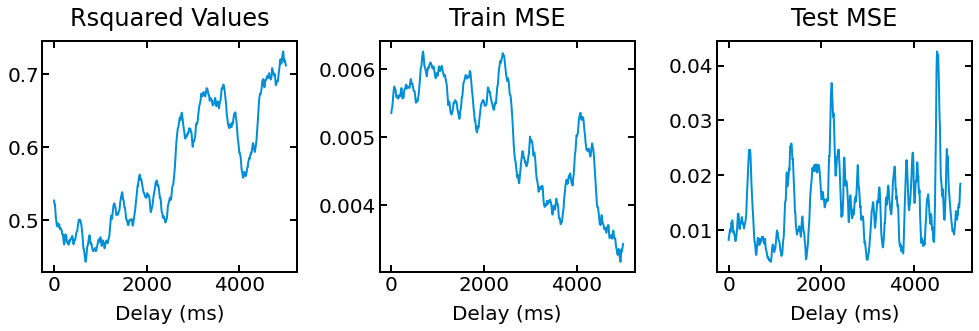

In [87]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(delays, rsquared_vals.mean(axis=0))
plt.xlabel('Delay (ms)')
plt.title("Rsquared Values")
plt.subplot(1, 3, 2)
plt.plot(delays, train_MSE.mean(axis=0))
plt.xlabel('Delay (ms)')
plt.title("Train MSE")
plt.subplot(1, 3, 3)
plt.plot(delays, test_MSE.mean(axis=0))
plt.xlabel('Delay (ms)')
plt.title("Test MSE")
plt.tight_layout()
plt.show()